In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA       # Needed for PCA of embeddings
import os


In [8]:
P = 113
MAX = 100

# Create the dataset
# set_seed(SEED)
data = []
for i in range(MAX):
    for j in range(MAX):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = 32
train_data = torch.tensor(train_data, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.long)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
D_EMBED = 128
HIDDEN = 256
P = 113

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(MAX, D_EMBED)
        self.lstm = nn.LSTM(input_size=D_EMBED, 
                            hidden_size=HIDDEN, 
                             batch_first=True)
        self.linear = nn.Linear(HIDDEN, P)
        self.init_weights()

    def forward(self, x1, x2):
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.stack((x1, x2), dim=1)
        _, (h_n, _) = self.lstm(x)
        x = self.linear(h_n[-1])
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [10]:
NB_EPOCHS = 5000
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1


# model = RNN()
model = RNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 20    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        optimizer.zero_grad()
        output = model(x1,x2)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y) # output is 59, y is 64?
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")
        
torch.save(model.state_dict(), f"model.pth")

0/5000: Train loss=4.7298, acc=0.8%  /  Test loss=4.7306, acc=0.5%
20/5000: Train loss=3.4193, acc=12.1%  /  Test loss=3.6385, acc=3.5%
40/5000: Train loss=2.5221, acc=26.5%  /  Test loss=2.7052, acc=12.9%
60/5000: Train loss=2.2465, acc=35.4%  /  Test loss=2.4316, acc=17.9%
80/5000: Train loss=2.1152, acc=39.8%  /  Test loss=2.3122, acc=19.8%
100/5000: Train loss=2.0546, acc=42.0%  /  Test loss=2.2610, acc=20.6%
120/5000: Train loss=2.0210, acc=42.8%  /  Test loss=2.2370, acc=20.3%
140/5000: Train loss=1.9988, acc=43.6%  /  Test loss=2.2177, acc=21.3%
160/5000: Train loss=1.9795, acc=44.0%  /  Test loss=2.1992, acc=21.4%
180/5000: Train loss=1.9621, acc=44.8%  /  Test loss=2.1848, acc=22.3%
200/5000: Train loss=1.9480, acc=45.4%  /  Test loss=2.1720, acc=22.3%
220/5000: Train loss=1.9324, acc=46.4%  /  Test loss=2.1584, acc=22.4%
240/5000: Train loss=1.9202, acc=46.8%  /  Test loss=2.1482, acc=23.1%
260/5000: Train loss=1.9089, acc=47.1%  /  Test loss=2.1386, acc=23.3%
280/5000: Train

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f"model.pth")

## Results

Plot the evolution of accuracy and loss during training

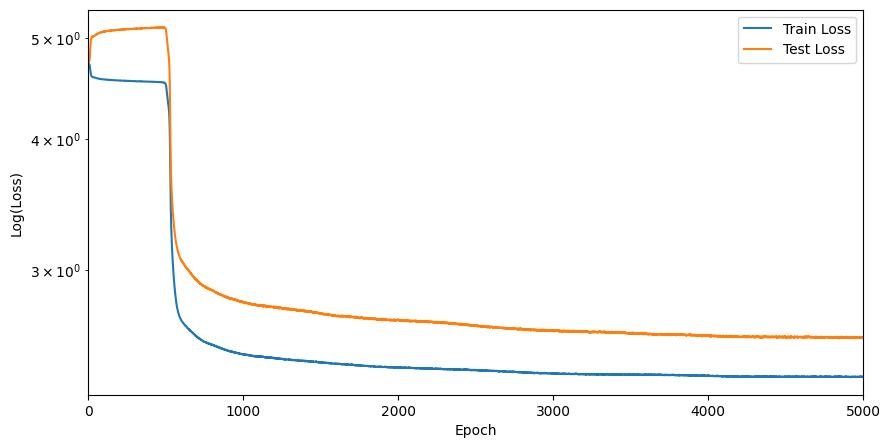

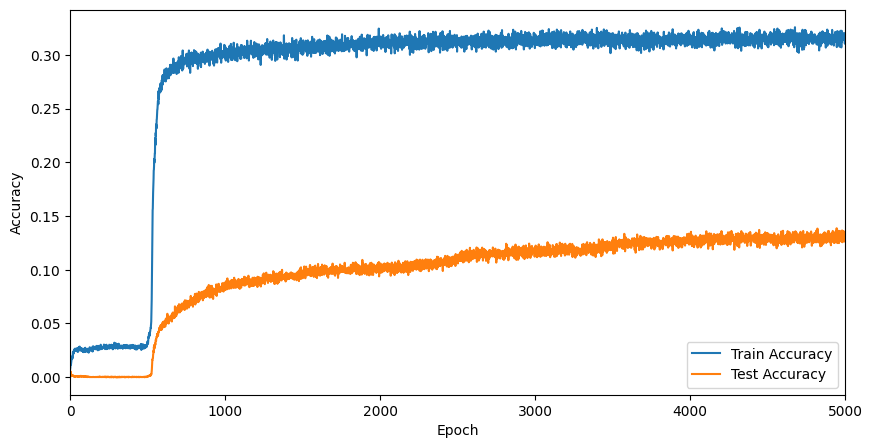

In [ ]:
NB_EPOCH_PLOT = 5000

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('loss_zoom.png', dpi=300)


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('accuracy_zoom.png', dpi=300)